# **Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision
from torchvision.transforms import v2
from tqdm.notebook import tqdm

import torchinfo
import optuna

import nndl.models.CNN as cnn
import nndl.models.CNNLSTM as cnnlstm
import nndl.utils as utils
import time

# **Load Data From LocalHost**

In [2]:
X_test = np.load("./project_data/X_test.npy")
y_test = np.load("./project_data/y_test.npy") - 769
person_train_valid = np.load("./project_data/person_train_valid.npy")
X_train_valid = np.load("./project_data/X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("./project_data/y_train_valid.npy") - 769
person_test = np.load("./project_data/person_test.npy")

print(X_train_valid.shape)
print(X_test.shape)

print(y_train_valid)

(2115, 22, 1000)
(2115, 22, 1000)
(443, 22, 1000)
[2 3 0 ... 3 3 2]


# **Device Setup**

In [3]:
if torch.cuda.is_available():
  device = torch.device('cuda')
elif torch.backends.mps.is_available():
  device = torch.device('mps')
else:
  device = torch.device('cpu')

print("Using", device)

Using cuda


# **Data Prep**

In [4]:
def data_prep(X,y,sub_sample,average,noise,channel_dropout,time_reverse):

    total_X = None
    total_y = None
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)

    X_max, _ = torch.max(X.view(X.size(0), X.size(1), -1, sub_sample), axis=3)


    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)

    X_average = torch.mean(X.view(X.size(0), X.size(1), -1, average), axis=3)
    X_average = X_average + torch.normal(0.0, 0.5, X_average.shape)

    total_X = torch.cat((total_X, X_average), dim=0)
    total_y = torch.cat((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)

    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                            (torch.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

        total_X = torch.cat((total_X, X_subsample), dim=0)
        print(total_y.view(-1,1).shape)
        print(y.view(-1,1).shape)
        total_y = torch.cat((total_y, y))

    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)

    if channel_dropout != 0:
        mask = (torch.rand(total_X.shape[0], total_X.shape[1]) >= channel_dropout).unsqueeze(2)
        X_dropout = mask * total_X
        total_X = torch.cat((total_X, X_dropout))
        total_y = torch.cat((total_y, total_y))

        print(f'Shape of X after channel dropout {total_X.shape}')
        print(f'Shape of Y: {total_y.shape}')

    if time_reverse != 0:
        mask = (torch.rand(total_X.shape[0]) >= time_reverse)
        X_reverse = torch.flip((total_X[mask]), [2])
        total_X = torch.cat((total_X, X_reverse))
        total_y = torch.cat((total_y, total_y[mask]))

        print(f'Shape of X after reverse {total_X.shape}')
        print(f'Shape of Y: {total_y.shape}')


    return total_X,total_y
    return total_X,total_y


def test_data_prep(X):

    total_X = None

    X = X[:,:,0:800]
    print('Shape of X after trimming:', X.shape)
    X_max, _ = torch.max(X.view(X.size(0), X.size(1), -1, 2), axis=3)

    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)

    return total_X

In [5]:
input_size = 22
hidden_size = 256
num_layers = 10
num_classes = 4
learning_rate = 0.001
batch_size = 200
num_epochs = 100
dropout = 0.3

folds = 10
split_seed = 1
subsample = 2
average = 2
channel_dropout = 0.2
time_reverse = 0.3
noise = True

X_train_valid = torch.Tensor(X_train_valid)
y_train_valid = torch.Tensor(y_train_valid)

print(f'SOME {X_train_valid.shape}')
indices = torch.randperm(X_train_valid.shape[0])
split_idx = int(X_train_valid.shape[0] * ((folds-1)/folds))
X_train, X_valid = X_train_valid[indices[:split_idx]], X_train_valid[indices[split_idx:]]
y_train, y_valid = y_train_valid[indices[:split_idx]], y_train_valid[indices[split_idx:]]
X_test, y_test = torch.Tensor(X_test), torch.Tensor(y_test)

print('Prepping Training Data')
X_train, y_train = data_prep(X_train, y_train, subsample, average, noise, channel_dropout, time_reverse)
print('\nPrepping Validation Data')
X_valid, y_valid = data_prep(X_valid, y_valid, subsample, average, noise, channel_dropout, time_reverse)
print('\nPrepping Test Data')
X_test = test_data_prep(X_test)
print('\nFINISHED PREP\n')

print('Final shape of training set:', X_train.shape)
print('Final shape of validation set:', X_valid.shape)
print('Final shape of test set:', X_test.shape)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_valid, y_valid), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=True)

print(f'TRAIN_DATA {len(train_loader)}\nVALID_DATA {len(val_loader)}\nTEST_DATA {len(test_loader)}')

SOME torch.Size([2115, 22, 1000])
Prepping Training Data
Shape of X after trimming: torch.Size([1903, 22, 800])
Shape of X after maxpooling: torch.Size([1903, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([3806, 22, 400])
torch.Size([3806, 1])
torch.Size([1903, 1])
torch.Size([5709, 1])
torch.Size([1903, 1])
Shape of X after subsampling and concatenating: torch.Size([7612, 22, 400])
Shape of Y: torch.Size([7612])
Shape of X after channel dropout torch.Size([15224, 22, 400])
Shape of Y: torch.Size([15224])
Shape of X after reverse torch.Size([25872, 22, 400])
Shape of Y: torch.Size([25872])

Prepping Validation Data
Shape of X after trimming: torch.Size([212, 22, 800])
Shape of X after maxpooling: torch.Size([212, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([424, 22, 400])
torch.Size([424, 1])
torch.Size([212, 1])
torch.Size([636, 1])
torch.Size([212, 1])
Shape of X after subsampling and concatenating: torch.Size([848, 22, 400])
Sh

# **CNN**

## Find Hyperparameters

In [ ]:
# time to measure exactly how much of my life i won't get back
start_time = time.time()
params = utils.learn_hyperparameters(X_train=X_train, 
                                     y_train=y_train, 
                                     X_valid=X_valid, 
                                     y_valid=y_valid, 
                                     model_name='CNN', 
                                     num_epochs=10, 
                                     trials=20)
optim_end = time.time()

[I 2024-03-11 20:15:40,853] A new study created in memory with name: no-name-6fd90d22-f061-4f53-bedb-feff5da96b17


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         256
    Optimizer:                          Adamax
        Learning Rate:                  0.003419325947419619
        Weight Decay:                   7.841426200752724e-05
    Model:                              CNN
        Dropout:                        0.4305338212776833
        (Block 1) Conv1d Kernel Size:   6
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   4
        (Block 3) Conv1d Kernel Size:   6
        Pool Kernel Size:               5
        Depth:                          50
Epoch 1


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.365, Val acc: 0.380, Val loss: 1.834
Epoch 2


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.476, Val acc: 0.422, Val loss: 1.576
Epoch 3


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.522, Val acc: 0.439, Val loss: 1.577
Epoch 4


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.555, Val acc: 0.441, Val loss: 1.564
Epoch 5


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.590, Val acc: 0.466, Val loss: 1.540
Epoch 6


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.614, Val acc: 0.466, Val loss: 1.662
Epoch 7


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.636, Val acc: 0.485, Val loss: 1.691
Epoch 8


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.660, Val acc: 0.476, Val loss: 1.749
Epoch 9


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.681, Val acc: 0.508, Val loss: 1.809
Epoch 10


  0%|          | 0/102 [00:00<?, ?it/s]

[I 2024-03-11 20:16:17,748] Trial 0 finished with value: 0.5079639554023743 and parameters: {'batch_size': 256, 'optimizer_name': 'Adamax', 'learning_rate': 0.003419325947419619, 'weight_decay': 7.841426200752724e-05, 'momentum': 0.8781418823441894, 'dropout': 0.4305338212776833, 'kernel1': 6, 'kernel2': '(1, 22)', 'kernel3': 4, 'kernel4': 6, 'pool_kernel': 5, 'depth': 50, 'hidden_dims': 64}. Best is trial 0 with value: 0.5079639554023743.


Train acc: 0.694, Val acc: 0.507, Val loss: 1.848
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Optimizer:                          SGD
        Learning Rate:                  0.0005556300287132576
        Weight Decay:                   1.5211106959200949e-05
        Momentum:                       0.8275951321185075
    Model:                              CNN
        Dropout:                        0.6167042253356279
        (Block 1) Conv1d Kernel Size:   5
        (Block 1) Conv2d Kernel Size:   (1, 25)
        (Block 2) Conv1d Kernel Size:   3
        (Block 3) Conv1d Kernel Size:   5
        Pool Kernel Size:               2
        Depth:                          50
Epoch 1


  0%|          | 0/405 [00:00<?, ?it/s]

Train acc: 0.315, Val acc: 0.379, Val loss: 1.505
Epoch 2


  0%|          | 0/405 [00:00<?, ?it/s]

Train acc: 0.368, Val acc: 0.407, Val loss: 1.924
Epoch 3


  0%|          | 0/405 [00:00<?, ?it/s]

Train acc: 0.393, Val acc: 0.448, Val loss: 1.681
Epoch 4


  0%|          | 0/405 [00:00<?, ?it/s]

Train acc: 0.411, Val acc: 0.443, Val loss: 1.641
Epoch 5


  0%|          | 0/405 [00:00<?, ?it/s]

Train acc: 0.426, Val acc: 0.446, Val loss: 2.122
Epoch 6


  0%|          | 0/405 [00:00<?, ?it/s]

Train acc: 0.439, Val acc: 0.411, Val loss: 2.778
Epoch 7


  0%|          | 0/405 [00:00<?, ?it/s]

Train acc: 0.457, Val acc: 0.414, Val loss: 2.662
Epoch 8


  0%|          | 0/405 [00:00<?, ?it/s]

Train acc: 0.465, Val acc: 0.417, Val loss: 2.428
Epoch 9


  0%|          | 0/405 [00:00<?, ?it/s]

Train acc: 0.471, Val acc: 0.428, Val loss: 2.348
Epoch 10


  0%|          | 0/405 [00:00<?, ?it/s]

[I 2024-03-11 20:17:21,930] Trial 1 finished with value: 0.4532548487186432 and parameters: {'batch_size': 64, 'optimizer_name': 'SGD', 'learning_rate': 0.0005556300287132576, 'weight_decay': 1.5211106959200949e-05, 'momentum': 0.8275951321185075, 'dropout': 0.6167042253356279, 'kernel1': 5, 'kernel2': '(1, 25)', 'kernel3': 3, 'kernel4': 5, 'pool_kernel': 2, 'depth': 50, 'hidden_dims': 128}. Best is trial 0 with value: 0.5079639554023743.


Train acc: 0.485, Val acc: 0.453, Val loss: 2.200
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         256
    Optimizer:                          SGD
        Learning Rate:                  0.0011442812239405309
        Weight Decay:                   0.0035843147160620056
        Momentum:                       0.8266207468625151
    Model:                              CNN
        Dropout:                        0.41093718757269004
        (Block 1) Conv1d Kernel Size:   3
        (Block 1) Conv2d Kernel Size:   (1, 17)
        (Block 2) Conv1d Kernel Size:   2
        (Block 3) Conv1d Kernel Size:   2
        Pool Kernel Size:               2
        Depth:                          50
Epoch 1


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.365, Val acc: 0.426, Val loss: 1.354
Epoch 2


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.449, Val acc: 0.461, Val loss: 1.351
Epoch 3


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.494, Val acc: 0.472, Val loss: 1.344
Epoch 4


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.514, Val acc: 0.466, Val loss: 1.403
Epoch 5


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.524, Val acc: 0.467, Val loss: 1.342
Epoch 6


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.541, Val acc: 0.465, Val loss: 1.528
Epoch 7


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.552, Val acc: 0.466, Val loss: 1.456
Epoch 8


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.567, Val acc: 0.450, Val loss: 1.655
Epoch 9


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.580, Val acc: 0.471, Val loss: 1.553
Epoch 10


  0%|          | 0/102 [00:00<?, ?it/s]

[I 2024-03-11 20:18:04,850] Trial 2 finished with value: 0.47160664200782776 and parameters: {'batch_size': 256, 'optimizer_name': 'SGD', 'learning_rate': 0.0011442812239405309, 'weight_decay': 0.0035843147160620056, 'momentum': 0.8266207468625151, 'dropout': 0.41093718757269004, 'kernel1': 3, 'kernel2': '(1, 17)', 'kernel3': 2, 'kernel4': 2, 'pool_kernel': 2, 'depth': 50, 'hidden_dims': 128}. Best is trial 0 with value: 0.5079639554023743.


Train acc: 0.585, Val acc: 0.456, Val loss: 1.501
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         128
    Optimizer:                          Adam
        Learning Rate:                  0.009630798438157855
        Weight Decay:                   0.0009963098454292647
    Model:                              CNN
        Dropout:                        0.7898286958329447
        (Block 1) Conv1d Kernel Size:   2
        (Block 1) Conv2d Kernel Size:   (1, 17)
        (Block 2) Conv1d Kernel Size:   7
        (Block 3) Conv1d Kernel Size:   5
        Pool Kernel Size:               3
        Depth:                          100
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.295, Val acc: 0.262, Val loss: 1.379
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.314, Val acc: 0.275, Val loss: 1.428
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.315, Val acc: 0.223, Val loss: 1.428
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.354, Val acc: 0.270, Val loss: 1.538
Epoch 5


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.378, Val acc: 0.267, Val loss: 1.585
Epoch 6


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.387, Val acc: 0.309, Val loss: 1.646
Epoch 7


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.390, Val acc: 0.328, Val loss: 1.472
Epoch 8


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.403, Val acc: 0.367, Val loss: 1.429
Epoch 9


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.423, Val acc: 0.325, Val loss: 1.554
Epoch 10


  0%|          | 0/203 [00:00<?, ?it/s]

## Model Summary

In [ ]:
model = cnn.CNN(num_classes=4,
                dropout=params.get('dropout'),
                kernel1=params.get('kernel1'),
                kernel2=eval(params.get('kernel2')),
                kernel3=params.get('kernel3'),
                kernel4=params.get('kernel4'),
                pool_kernel=params.get('pool_kernel'),
                depth=params.get('depth'),
                scale=params.get('scale')).to(device)


torchinfo.summary(model, input_size=(batch_size, 22, 400))

## Training with Learned Hyperparameters

In [ ]:
criterion = nn.CrossEntropyLoss()
if params.get('optimizer_name') == 'RMSprop' or params.get('optimizer_name') == 'SGD':
    optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
                                                                    lr=params.get('learning_rate'),
                                                                    weight_decay=params.get('weight_decay'),
                                                                    momentum=params.get('momentum'))
else:
    optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
                                                                    lr=params.get('learning_rate'),
                                                                    weight_decay=params.get('weight_decay'))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

train_accuracies, val_accuracies = utils.train_model(model, 
                                                     criterion, 
                                                     optimizer, 
                                                     scheduler, 
                                                     train_loader=train_loader, 
                                                     val_loader=val_loader, 
                                                     num_epochs=100)

## Training and Accuracy Graph

In [ ]:
import matplotlib.pyplot as plt
num_epochs = 100
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

utils.test_model(model, test_loader)
end_time = time.time()

hours = (optim_end - start_time) // 3600
minutes = ((optim_end - start_time) % 3600) // 60
seconds = (optim_end - start_time) % 60

print(f'time to train hyperparameters: \
{hours} hours, \
{minutes} minutes, \
{int(seconds)} seconds')

print(f'time to train model: \
{hours} hours, \
{minutes} minutes, \
{int(seconds)} seconds')

# **CNN-LSTM**

## Find Hyperparameters

In [11]:
# time to measure exactly how much of my life i won't get back
start_time = time.time()
params = utils.learn_hyperparameters(X_train=X_train, 
                                     y_train=y_train, 
                                     X_valid=X_valid, 
                                     y_valid=y_valid, 
                                     model_name='CNNLSTM', 
                                     num_epochs=10, 
                                     trials=20)
optim_end = time.time()

[I 2024-03-11 05:09:44,776] A new study created in memory with name: no-name-50d1fab9-3203-426f-a02e-9d1cb914ed2f


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         128
    Hidden Dimensions:                  64
    Optimizer:                          SGD
        Learning Rate:                  0.002681638559247825
        Weight Decay:                   0.0005595405413719119
        Momentum:                       0.8396016751513767
    Model:                              CNNLSTM
        Dropout:                        0.4961320760316572
        (Block 1) Conv1d Kernel Size:   7
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   4
        (Block 3) Conv1d Kernel Size:   4
        Pool Kernel Size:               4
        Depth:                          22
        Scale:                          2
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.258, Val acc: 0.213, Val loss: 1.385
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.266, Val acc: 0.221, Val loss: 1.386
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.275, Val acc: 0.211, Val loss: 1.385
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.289, Val acc: 0.215, Val loss: 1.385


[I 2024-03-11 05:10:01,202] Trial 0 pruned. 


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         128
    Hidden Dimensions:                  32
    Optimizer:                          SGD
        Learning Rate:                  0.004846116940275821
        Weight Decay:                   3.778614662430099e-06
        Momentum:                       0.8826844505026615
    Model:                              CNNLSTM
        Dropout:                        0.5750520102159097
        (Block 1) Conv1d Kernel Size:   9
        (Block 1) Conv2d Kernel Size:   (1, 25)
        (Block 2) Conv1d Kernel Size:   3
        (Block 3) Conv1d Kernel Size:   7
        Pool Kernel Size:               5
        Depth:                          22
        Scale:                          2
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.246, Val acc: 0.212, Val loss: 1.385
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.254, Val acc: 0.212, Val loss: 1.383
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.255, Val acc: 0.212, Val loss: 1.383
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

[I 2024-03-11 05:10:17,626] Trial 1 pruned. 


Train acc: 0.258, Val acc: 0.212, Val loss: 1.383
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Hidden Dimensions:                  64
    Optimizer:                          RMSprop
        Learning Rate:                  0.0022568356529607363
        Weight Decay:                   1.5047645032869539e-06
        Momentum:                       0.9309347454725664
    Model:                              CNNLSTM
        Dropout:                        0.56973696278004
        (Block 1) Conv1d Kernel Size:   8
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   7
        (Block 3) Conv1d Kernel Size:   7
        Pool Kernel Size:               2
        Depth:                          22
        Scale:                          2
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.254, Val acc: 0.282, Val loss: 1.434
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.252, Val acc: 0.283, Val loss: 1.405
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.246, Val acc: 0.253, Val loss: 1.396
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.254, Val acc: 0.283, Val loss: 1.399
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.251, Val acc: 0.212, Val loss: 1.393


[I 2024-03-11 05:10:55,530] Trial 2 pruned. 


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Hidden Dimensions:                  256
    Optimizer:                          SGD
        Learning Rate:                  0.003924450733481583
        Weight Decay:                   0.005556846825422449
        Momentum:                       0.832310486461166
    Model:                              CNNLSTM
        Dropout:                        0.5104284828509007
        (Block 1) Conv1d Kernel Size:   2
        (Block 1) Conv2d Kernel Size:   (1, 25)
        (Block 2) Conv1d Kernel Size:   6
        (Block 3) Conv1d Kernel Size:   3
        Pool Kernel Size:               5
        Depth:                          22
        Scale:                          2
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.252, Val acc: 0.212, Val loss: 1.383
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.271, Val acc: 0.212, Val loss: 1.379
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.280, Val acc: 0.221, Val loss: 1.377
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

[I 2024-03-11 05:12:05,770] Trial 3 pruned. 


Train acc: 0.287, Val acc: 0.232, Val loss: 1.373
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Hidden Dimensions:                  32
    Optimizer:                          Adam
        Learning Rate:                  0.005182111685772867
        Weight Decay:                   0.0004937964759299547
    Model:                              CNNLSTM
        Dropout:                        0.5026501849964197
        (Block 1) Conv1d Kernel Size:   7
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   6
        (Block 3) Conv1d Kernel Size:   4
        Pool Kernel Size:               3
        Depth:                          22
        Scale:                          2
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.336, Val acc: 0.370, Val loss: 1.245
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.404, Val acc: 0.373, Val loss: 1.144
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.409, Val acc: 0.431, Val loss: 1.140
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.412, Val acc: 0.429, Val loss: 1.136
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.417, Val acc: 0.399, Val loss: 1.080
Epoch 6


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.414, Val acc: 0.461, Val loss: 1.069
Epoch 7


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.423, Val acc: 0.427, Val loss: 1.177
Epoch 8


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.430, Val acc: 0.444, Val loss: 1.038
Epoch 9


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.435, Val acc: 0.445, Val loss: 0.919
Epoch 10


  0%|          | 0/406 [00:00<?, ?it/s]

[I 2024-03-11 05:13:20,575] Trial 4 finished with value: 0.46447139978408813 and parameters: {'batch_size': 64, 'optimizer_name': 'Adam', 'learning_rate': 0.005182111685772867, 'weight_decay': 0.0004937964759299547, 'momentum': 0.8635074021524499, 'dropout': 0.5026501849964197, 'kernel1': 7, 'kernel2': '(1, 22)', 'kernel3': 6, 'kernel4': 4, 'pool_kernel': 3, 'depth': 150, 'scale': 5, 'hidden_dims': 32}. Best is trial 4 with value: 0.46447139978408813.


Train acc: 0.444, Val acc: 0.464, Val loss: 1.075
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         256
    Hidden Dimensions:                  32
    Optimizer:                          Adam
        Learning Rate:                  0.004092107789235703
        Weight Decay:                   0.002604826482702102
    Model:                              CNNLSTM
        Dropout:                        0.40351056406014263
        (Block 1) Conv1d Kernel Size:   2
        (Block 1) Conv2d Kernel Size:   (1, 25)
        (Block 2) Conv1d Kernel Size:   7
        (Block 3) Conv1d Kernel Size:   2
        Pool Kernel Size:               5
        Depth:                          22
        Scale:                          2
Epoch 1


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.298, Val acc: 0.345, Val loss: 1.307
Epoch 2


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.387, Val acc: 0.387, Val loss: 1.265
Epoch 3


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.409, Val acc: 0.407, Val loss: 1.308
Epoch 4


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.425, Val acc: 0.404, Val loss: 1.287
Epoch 5


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.439, Val acc: 0.393, Val loss: 1.332
Epoch 6


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.446, Val acc: 0.424, Val loss: 1.320
Epoch 7


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.446, Val acc: 0.437, Val loss: 1.273
Epoch 8


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.453, Val acc: 0.421, Val loss: 1.341
Epoch 9


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.450, Val acc: 0.436, Val loss: 1.303
Epoch 10


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.457, Val acc: 0.415, Val loss: 1.336


[I 2024-03-11 05:13:46,621] Trial 5 finished with value: 0.43708840012550354 and parameters: {'batch_size': 256, 'optimizer_name': 'Adam', 'learning_rate': 0.004092107789235703, 'weight_decay': 0.002604826482702102, 'momentum': 0.9779098010372821, 'dropout': 0.40351056406014263, 'kernel1': 2, 'kernel2': '(1, 25)', 'kernel3': 7, 'kernel4': 2, 'pool_kernel': 5, 'depth': 25, 'scale': 2, 'hidden_dims': 32}. Best is trial 4 with value: 0.46447139978408813.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Hidden Dimensions:                  32
    Optimizer:                          NAdam
        Learning Rate:                  0.0006377570159142858
        Weight Decay:                   1.788658543630336e-05
    Model:                              CNNLSTM
        Dropout:                        0.43543892945794066
        (Block 1) Conv1d Kernel Size:   4
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   4
        (Block 3) Conv1d Kernel Size:   3
        Pool Kernel Size:               5
        Depth:                          22
        Scale:                          2
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.284, Val acc: 0.261, Val loss: 1.361
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.335, Val acc: 0.301, Val loss: 1.381
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.358, Val acc: 0.307, Val loss: 1.515
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.366, Val acc: 0.303, Val loss: 1.342
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.376, Val acc: 0.302, Val loss: 1.371
Epoch 6


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.384, Val acc: 0.312, Val loss: 1.494
Epoch 7


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.382, Val acc: 0.319, Val loss: 1.397
Epoch 8


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.396, Val acc: 0.319, Val loss: 1.510
Epoch 9


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.420, Val acc: 0.358, Val loss: 1.374
Epoch 10


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.419, Val acc: 0.359, Val loss: 1.241


[I 2024-03-11 05:15:02,218] Trial 6 finished with value: 0.35875216126441956 and parameters: {'batch_size': 64, 'optimizer_name': 'NAdam', 'learning_rate': 0.0006377570159142858, 'weight_decay': 1.788658543630336e-05, 'momentum': 0.9009876812408784, 'dropout': 0.43543892945794066, 'kernel1': 4, 'kernel2': '(1, 22)', 'kernel3': 4, 'kernel4': 3, 'pool_kernel': 5, 'depth': 150, 'scale': 5, 'hidden_dims': 32}. Best is trial 4 with value: 0.46447139978408813.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         128
    Hidden Dimensions:                  256
    Optimizer:                          SGD
        Learning Rate:                  0.00030677356369238236
        Weight Decay:                   3.383963635692009e-05
        Momentum:                       0.9664239695298955
    Model:                              CNNLSTM
        Dropout:                        0.6327037565783107
        (Block 1) Conv1d Kernel Size:   2
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   4
        (Block 3) Conv1d Kernel Size:   2
        Pool Kernel Size:               4
        Depth:                          22
        Scale:                          2
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.251, Val acc: 0.283, Val loss: 1.386
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.257, Val acc: 0.211, Val loss: 1.385
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.259, Val acc: 0.212, Val loss: 1.384
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

[I 2024-03-11 05:15:41,519] Trial 7 pruned. 


Train acc: 0.260, Val acc: 0.212, Val loss: 1.383
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Hidden Dimensions:                  16
    Optimizer:                          Adamax
        Learning Rate:                  0.002227742683487569
        Weight Decay:                   3.212721619189215e-06
    Model:                              CNNLSTM
        Dropout:                        0.4118963677663743
        (Block 1) Conv1d Kernel Size:   3
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   6
        (Block 3) Conv1d Kernel Size:   4
        Pool Kernel Size:               2
        Depth:                          22
        Scale:                          2
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.268, Val acc: 0.261, Val loss: 1.391
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.305, Val acc: 0.288, Val loss: 1.391
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.359, Val acc: 0.358, Val loss: 1.318
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.384, Val acc: 0.402, Val loss: 1.221
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.407, Val acc: 0.426, Val loss: 1.206
Epoch 6


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.422, Val acc: 0.431, Val loss: 1.191
Epoch 7


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.436, Val acc: 0.430, Val loss: 1.188
Epoch 8


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.447, Val acc: 0.429, Val loss: 1.150
Epoch 9


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.454, Val acc: 0.431, Val loss: 1.212
Epoch 10


  0%|          | 0/406 [00:00<?, ?it/s]

[I 2024-03-11 05:17:13,382] Trial 8 finished with value: 0.441247820854187 and parameters: {'batch_size': 64, 'optimizer_name': 'Adamax', 'learning_rate': 0.002227742683487569, 'weight_decay': 3.212721619189215e-06, 'momentum': 0.9846813200732064, 'dropout': 0.4118963677663743, 'kernel1': 3, 'kernel2': '(1, 22)', 'kernel3': 6, 'kernel4': 4, 'pool_kernel': 2, 'depth': 100, 'scale': 2, 'hidden_dims': 16}. Best is trial 4 with value: 0.46447139978408813.


Train acc: 0.464, Val acc: 0.441, Val loss: 1.173
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Hidden Dimensions:                  256
    Optimizer:                          NAdam
        Learning Rate:                  0.003051707984160668
        Weight Decay:                   0.0006308846101282516
    Model:                              CNNLSTM
        Dropout:                        0.42977160242592227
        (Block 1) Conv1d Kernel Size:   5
        (Block 1) Conv2d Kernel Size:   (1, 25)
        (Block 2) Conv1d Kernel Size:   5
        (Block 3) Conv1d Kernel Size:   5
        Pool Kernel Size:               5
        Depth:                          22
        Scale:                          2
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.285, Val acc: 0.332, Val loss: 1.401
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.314, Val acc: 0.326, Val loss: 1.231
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.360, Val acc: 0.378, Val loss: 1.152
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.400, Val acc: 0.416, Val loss: 1.123
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.296, Val acc: 0.226, Val loss: 1.408


[I 2024-03-11 05:18:41,107] Trial 9 pruned. 


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         256
    Hidden Dimensions:                  128
    Optimizer:                          Adam
        Learning Rate:                  0.008747256091848397
        Weight Decay:                   0.00022690745080871614
    Model:                              CNNLSTM
        Dropout:                        0.7774549027306548
        (Block 1) Conv1d Kernel Size:   10
        (Block 1) Conv2d Kernel Size:   (1, 17)
        (Block 2) Conv1d Kernel Size:   2
        (Block 3) Conv1d Kernel Size:   6
        Pool Kernel Size:               3
        Depth:                          22
        Scale:                          2
Epoch 1


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.274, Val acc: 0.299, Val loss: 1.401
Epoch 2


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.345, Val acc: 0.316, Val loss: 1.365
Epoch 3


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.371, Val acc: 0.331, Val loss: 1.360
Epoch 4


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.377, Val acc: 0.273, Val loss: 1.385


[I 2024-03-11 05:18:57,377] Trial 10 pruned. 


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Hidden Dimensions:                  16
    Optimizer:                          Adamax
        Learning Rate:                  0.0012558083189720525
        Weight Decay:                   5.921947459517738e-05
    Model:                              CNNLSTM
        Dropout:                        0.4969493439432344
        (Block 1) Conv1d Kernel Size:   5
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   6
        (Block 3) Conv1d Kernel Size:   4
        Pool Kernel Size:               2
        Depth:                          22
        Scale:                          2
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.249, Val acc: 0.267, Val loss: 1.386
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.265, Val acc: 0.287, Val loss: 1.351
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.297, Val acc: 0.389, Val loss: 1.358
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.350, Val acc: 0.421, Val loss: 1.330
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.381, Val acc: 0.416, Val loss: 1.247
Epoch 6


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.395, Val acc: 0.416, Val loss: 1.236
Epoch 7


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.403, Val acc: 0.418, Val loss: 1.298
Epoch 8


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.408, Val acc: 0.418, Val loss: 1.349
Epoch 9


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.416, Val acc: 0.431, Val loss: 1.346
Epoch 10


  0%|          | 0/406 [00:00<?, ?it/s]

[I 2024-03-11 05:20:30,033] Trial 11 finished with value: 0.43084922432899475 and parameters: {'batch_size': 64, 'optimizer_name': 'Adamax', 'learning_rate': 0.0012558083189720525, 'weight_decay': 5.921947459517738e-05, 'momentum': 0.8735639331892612, 'dropout': 0.4969493439432344, 'kernel1': 5, 'kernel2': '(1, 22)', 'kernel3': 6, 'kernel4': 4, 'pool_kernel': 2, 'depth': 100, 'scale': 4, 'hidden_dims': 16}. Best is trial 4 with value: 0.46447139978408813.


Train acc: 0.423, Val acc: 0.419, Val loss: 1.367
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Hidden Dimensions:                  16
    Optimizer:                          Adamax
        Learning Rate:                  0.00012787939853683275
        Weight Decay:                   6.910659274245531e-06
    Model:                              CNNLSTM
        Dropout:                        0.6463201756959247
        (Block 1) Conv1d Kernel Size:   7
        (Block 1) Conv2d Kernel Size:   (1, 17)
        (Block 2) Conv1d Kernel Size:   6
        (Block 3) Conv1d Kernel Size:   5
        Pool Kernel Size:               3
        Depth:                          22
        Scale:                          2
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.255, Val acc: 0.212, Val loss: 1.266
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.259, Val acc: 0.212, Val loss: 1.272
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.257, Val acc: 0.212, Val loss: 1.279
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.262, Val acc: 0.212, Val loss: 1.284


[I 2024-03-11 05:21:07,192] Trial 12 pruned. 


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Hidden Dimensions:                  16
    Optimizer:                          Adam
        Learning Rate:                  0.009839712408012851
        Weight Decay:                   0.00014939086554806899
    Model:                              CNNLSTM
        Dropout:                        0.4764719938211102
        (Block 1) Conv1d Kernel Size:   4
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   5
        (Block 3) Conv1d Kernel Size:   4
        Pool Kernel Size:               2
        Depth:                          22
        Scale:                          2
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.329, Val acc: 0.401, Val loss: 1.206
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.401, Val acc: 0.428, Val loss: 1.285
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.415, Val acc: 0.403, Val loss: 1.305
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.423, Val acc: 0.434, Val loss: 1.227
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.425, Val acc: 0.406, Val loss: 1.087
Epoch 6


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.430, Val acc: 0.417, Val loss: 1.253
Epoch 7


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.439, Val acc: 0.407, Val loss: 1.115
Epoch 8


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.439, Val acc: 0.425, Val loss: 1.165
Epoch 9


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.447, Val acc: 0.418, Val loss: 1.057
Epoch 10


  0%|          | 0/406 [00:00<?, ?it/s]

[I 2024-03-11 05:22:22,727] Trial 13 finished with value: 0.43396881222724915 and parameters: {'batch_size': 64, 'optimizer_name': 'Adam', 'learning_rate': 0.009839712408012851, 'weight_decay': 0.00014939086554806899, 'momentum': 0.8521215498452793, 'dropout': 0.4764719938211102, 'kernel1': 4, 'kernel2': '(1, 22)', 'kernel3': 5, 'kernel4': 4, 'pool_kernel': 2, 'depth': 200, 'scale': 5, 'hidden_dims': 16}. Best is trial 4 with value: 0.46447139978408813.


Train acc: 0.449, Val acc: 0.398, Val loss: 1.068
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Hidden Dimensions:                  128
    Optimizer:                          Adamax
        Learning Rate:                  0.0012570465836046567
        Weight Decay:                   0.001048339890891603
    Model:                              CNNLSTM
        Dropout:                        0.5338969374641107
        (Block 1) Conv1d Kernel Size:   6
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   6
        (Block 3) Conv1d Kernel Size:   3
        Pool Kernel Size:               3
        Depth:                          22
        Scale:                          2
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.330, Val acc: 0.413, Val loss: 1.299
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.398, Val acc: 0.396, Val loss: 1.108
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.411, Val acc: 0.393, Val loss: 1.065
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.424, Val acc: 0.401, Val loss: 1.137
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.435, Val acc: 0.412, Val loss: 1.136
Epoch 6


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.437, Val acc: 0.409, Val loss: 1.095
Epoch 7


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.442, Val acc: 0.409, Val loss: 1.159
Epoch 8


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.454, Val acc: 0.423, Val loss: 1.176
Epoch 9


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.463, Val acc: 0.427, Val loss: 1.216
Epoch 10


  0%|          | 0/406 [00:00<?, ?it/s]

[I 2024-03-11 05:23:53,302] Trial 14 finished with value: 0.4270364046096802 and parameters: {'batch_size': 64, 'optimizer_name': 'Adamax', 'learning_rate': 0.0012570465836046567, 'weight_decay': 0.001048339890891603, 'momentum': 0.9406552042778109, 'dropout': 0.5338969374641107, 'kernel1': 6, 'kernel2': '(1, 22)', 'kernel3': 6, 'kernel4': 3, 'pool_kernel': 3, 'depth': 100, 'scale': 3, 'hidden_dims': 128}. Best is trial 4 with value: 0.46447139978408813.


Train acc: 0.477, Val acc: 0.421, Val loss: 1.358
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         256
    Hidden Dimensions:                  32
    Optimizer:                          RMSprop
        Learning Rate:                  0.0006315875746669627
        Weight Decay:                   1.543353531599272e-05
        Momentum:                       0.8658045458951797
    Model:                              CNNLSTM
        Dropout:                        0.7372633926761906
        (Block 1) Conv1d Kernel Size:   4
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   7
        (Block 3) Conv1d Kernel Size:   5
        Pool Kernel Size:               2
        Depth:                          22
        Scale:                          2
Epoch 1


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.265, Val acc: 0.349, Val loss: 1.381
Epoch 2


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.339, Val acc: 0.417, Val loss: 1.313
Epoch 3


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.380, Val acc: 0.408, Val loss: 1.315
Epoch 4


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.396, Val acc: 0.418, Val loss: 1.281
Epoch 5


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.399, Val acc: 0.410, Val loss: 1.314
Epoch 6


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.415, Val acc: 0.399, Val loss: 1.318
Epoch 7


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.414, Val acc: 0.393, Val loss: 1.312
Epoch 8


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.422, Val acc: 0.393, Val loss: 1.320
Epoch 9


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.423, Val acc: 0.387, Val loss: 1.311
Epoch 10


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.427, Val acc: 0.403, Val loss: 1.311


[I 2024-03-11 05:24:19,624] Trial 15 finished with value: 0.4180242717266083 and parameters: {'batch_size': 256, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0006315875746669627, 'weight_decay': 1.543353531599272e-05, 'momentum': 0.8658045458951797, 'dropout': 0.7372633926761906, 'kernel1': 4, 'kernel2': '(1, 22)', 'kernel3': 7, 'kernel4': 5, 'pool_kernel': 2, 'depth': 150, 'scale': 4, 'hidden_dims': 32}. Best is trial 4 with value: 0.46447139978408813.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Hidden Dimensions:                  16
    Optimizer:                          Adam
        Learning Rate:                  0.001546825635948739
        Weight Decay:                   0.00018254194580256077
    Model:                              CNNLSTM
        Dropout:                        0.45512227914263886
        (Block 1) Conv1d Kernel Size:   7
        (Block 1) Conv2d Kernel Size:   (1, 17)
        (Block 2) Conv1d Kernel Size:   5
        (Block 3) Conv1d Kernel Size:   6
        Pool Kernel Size:               3
        Depth:                          22
        Scale:                          2
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.338, Val acc: 0.416, Val loss: 1.143
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.400, Val acc: 0.415, Val loss: 1.151
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.413, Val acc: 0.416, Val loss: 1.209
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.425, Val acc: 0.418, Val loss: 1.277
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.431, Val acc: 0.432, Val loss: 1.156
Epoch 6


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.451, Val acc: 0.435, Val loss: 1.452
Epoch 7


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.469, Val acc: 0.455, Val loss: 1.235
Epoch 8


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.485, Val acc: 0.472, Val loss: 1.432
Epoch 9


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.497, Val acc: 0.488, Val loss: 1.523
Epoch 10


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.505, Val acc: 0.493, Val loss: 1.499


[I 2024-03-11 05:25:33,675] Trial 16 finished with value: 0.4932408928871155 and parameters: {'batch_size': 64, 'optimizer_name': 'Adam', 'learning_rate': 0.001546825635948739, 'weight_decay': 0.00018254194580256077, 'momentum': 0.9069342595487224, 'dropout': 0.45512227914263886, 'kernel1': 7, 'kernel2': '(1, 17)', 'kernel3': 5, 'kernel4': 6, 'pool_kernel': 3, 'depth': 100, 'scale': 5, 'hidden_dims': 16}. Best is trial 16 with value: 0.4932408928871155.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Hidden Dimensions:                  16
    Optimizer:                          Adam
        Learning Rate:                  0.0057851449247431725
        Weight Decay:                   0.0001650076926169088
    Model:                              CNNLSTM
        Dropout:                        0.46265098109915254
        (Block 1) Conv1d Kernel Size:   8
        (Block 1) Conv2d Kernel Size:   (1, 17)
        (Block 2) Conv1d Kernel Size:   5
        (Block 3) Conv1d Kernel Size:   6
        Pool Kernel Size:               4
        Depth:                          22
        Scale:                          2
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.318, Val acc: 0.393, Val loss: 1.287
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.390, Val acc: 0.434, Val loss: 1.204
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.399, Val acc: 0.414, Val loss: 1.249
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.406, Val acc: 0.404, Val loss: 1.287
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.418, Val acc: 0.368, Val loss: 1.039
Epoch 6


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.429, Val acc: 0.408, Val loss: 1.033
Epoch 7


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.439, Val acc: 0.446, Val loss: 1.083
Epoch 8


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.447, Val acc: 0.412, Val loss: 1.010
Epoch 9


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.451, Val acc: 0.450, Val loss: 1.116
Epoch 10


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.459, Val acc: 0.428, Val loss: 1.130


[I 2024-03-11 05:26:47,366] Trial 17 finished with value: 0.44956672191619873 and parameters: {'batch_size': 64, 'optimizer_name': 'Adam', 'learning_rate': 0.0057851449247431725, 'weight_decay': 0.0001650076926169088, 'momentum': 0.9053066214699917, 'dropout': 0.46265098109915254, 'kernel1': 8, 'kernel2': '(1, 17)', 'kernel3': 5, 'kernel4': 6, 'pool_kernel': 4, 'depth': 150, 'scale': 5, 'hidden_dims': 16}. Best is trial 16 with value: 0.4932408928871155.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         128
    Hidden Dimensions:                  32
    Optimizer:                          Adam
        Learning Rate:                  0.0007338282996969646
        Weight Decay:                   0.00984097477512793
    Model:                              CNNLSTM
        Dropout:                        0.5465729487630663
        (Block 1) Conv1d Kernel Size:   7
        (Block 1) Conv2d Kernel Size:   (1, 17)
        (Block 2) Conv1d Kernel Size:   3
        (Block 3) Conv1d Kernel Size:   6
        Pool Kernel Size:               3
        Depth:                          22
        Scale:                          2
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.283, Val acc: 0.251, Val loss: 1.375
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.368, Val acc: 0.280, Val loss: 1.317
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.388, Val acc: 0.320, Val loss: 1.300
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.403, Val acc: 0.339, Val loss: 1.302
Epoch 5


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.407, Val acc: 0.399, Val loss: 1.302
Epoch 6


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.411, Val acc: 0.353, Val loss: 1.294
Epoch 7


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.414, Val acc: 0.379, Val loss: 1.302
Epoch 8


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.414, Val acc: 0.374, Val loss: 1.334
Epoch 9


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.415, Val acc: 0.377, Val loss: 1.302
Epoch 10


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.416, Val acc: 0.380, Val loss: 1.303


[I 2024-03-11 05:27:29,392] Trial 18 finished with value: 0.39861351251602173 and parameters: {'batch_size': 128, 'optimizer_name': 'Adam', 'learning_rate': 0.0007338282996969646, 'weight_decay': 0.00984097477512793, 'momentum': 0.8217117341107333, 'dropout': 0.5465729487630663, 'kernel1': 7, 'kernel2': '(1, 17)', 'kernel3': 3, 'kernel4': 6, 'pool_kernel': 3, 'depth': 50, 'scale': 5, 'hidden_dims': 32}. Best is trial 16 with value: 0.4932408928871155.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         256
    Hidden Dimensions:                  128
    Optimizer:                          Adam
        Learning Rate:                  0.00036618660279759077
        Weight Decay:                   0.001697632540859746
    Model:                              CNNLSTM
        Dropout:                        0.6190505091007079
        (Block 1) Conv1d Kernel Size:   10
        (Block 1) Conv2d Kernel Size:   (1, 17)
        (Block 2) Conv1d Kernel Size:   5
        (Block 3) Conv1d Kernel Size:   6
        Pool Kernel Size:               3
        Depth:                          22
        Scale:                          2
Epoch 1


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.263, Val acc: 0.214, Val loss: 1.385
Epoch 2


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.321, Val acc: 0.236, Val loss: 1.374
Epoch 3


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.381, Val acc: 0.295, Val loss: 1.338
Epoch 4


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.404, Val acc: 0.277, Val loss: 1.355


[I 2024-03-11 05:27:45,767] Trial 19 pruned. 


Number of finished trials: 20
Best trial:
    Validation Accuracy: 0.4932408928871155
    Learned Hyperparameters
    ------------------------
    Batch Size:                         64
    Hidden Dimensions:                  16
    Optimizer:                          Adam
        Learning Rate:                  0.001546825635948739
        Weight Decay:                   0.00018254194580256077
    Model:                              CNNLSTM
        Dropout:                        0.45512227914263886
        (Block 1) Conv1d Kernel Size:   7
        (Block 1) Conv2d Kernel Size:   (1, 17)
        (Block 2) Conv1d Kernel Size:   5
        (Block 3) Conv1d Kernel Size:   6
        Pool Kernel Size:               3
        Depth:                          100
        Scale:                          5


## Model Summary

In [12]:
model = cnnlstm.CNNLSTM(num_classes=4,
                        hidden_dims=params.get('hidden_dims'),
                        dropout=params.get('dropout'),
                        kernel1=params.get('kernel1'),
                        kernel2=eval(params.get('kernel2')),
                        kernel3=params.get('kernel3'),
                        kernel4=params.get('kernel4'),
                        pool_kernel=params.get('pool_kernel'),
                        depth=params.get('depth'),
                        scale=params.get('scale')).to(device)


torchinfo.summary(model, input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
CNNLSTM                                  [200, 4]                  --
├─Sequential: 1-1                        [200, 100, 394]           --
│    └─Conv1d: 2-1                       [200, 100, 394]           15,500
│    └─ReLU: 2-2                         [200, 100, 394]           --
│    └─BatchNorm1d: 2-3                  [200, 100, 394]           200
│    └─Dropout: 2-4                      [200, 100, 394]           --
├─Sequential: 1-2                        [200, 100, 1, 126]        --
│    └─Conv2d: 2-5                       [200, 100, 1, 378]        170,100
│    └─ELU: 2-6                          [200, 100, 1, 378]        --
│    └─BatchNorm2d: 2-7                  [200, 100, 1, 378]        200
│    └─MaxPool2d: 2-8                    [200, 100, 1, 126]        --
│    └─Dropout: 2-9                      [200, 100, 1, 126]        --
├─Sequential: 1-3                        [200, 500, 40]            --
│   

## Training with Learned Hyperparameters

In [13]:
criterion = nn.CrossEntropyLoss()
if params.get('optimizer_name') == 'RMSprop' or params.get('optimizer_name') == 'SGD':
    optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
                                                                    lr=params.get('learning_rate'),
                                                                    weight_decay=params.get('weight_decay'),
                                                                    momentum=params.get('momentum'))
else:
    optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
                                                                    lr=params.get('learning_rate'),
                                                                    weight_decay=params.get('weight_decay'))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

train_accuracies, val_accuracies = utils.train_model(model, 
                                                     criterion, 
                                                     optimizer, 
                                                     scheduler, 
                                                     train_loader=train_loader, 
                                                     val_loader=val_loader, 
                                                     num_epochs=100)

Epoch 1


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.310, Val acc: 0.415, Val loss: 1.216
Epoch 2


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.399, Val acc: 0.424, Val loss: 1.274
Epoch 3


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.422, Val acc: 0.409, Val loss: 1.285
Epoch 4


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.438, Val acc: 0.415, Val loss: 1.358
Epoch 5


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.452, Val acc: 0.412, Val loss: 1.260
Epoch 6


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.469, Val acc: 0.423, Val loss: 1.142
Epoch 7


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.481, Val acc: 0.426, Val loss: 1.213
Epoch 8


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.500, Val acc: 0.430, Val loss: 1.410
Epoch 9


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.514, Val acc: 0.415, Val loss: 1.220
Epoch 10


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.532, Val acc: 0.419, Val loss: 1.488
Epoch 11


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.549, Val acc: 0.434, Val loss: 1.246
Epoch 12


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.555, Val acc: 0.426, Val loss: 1.300
Epoch 13


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.567, Val acc: 0.454, Val loss: 1.301
Epoch 14


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.574, Val acc: 0.449, Val loss: 1.504
Epoch 15


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.588, Val acc: 0.431, Val loss: 1.487
Epoch 16


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.596, Val acc: 0.420, Val loss: 1.315
Epoch 17


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.603, Val acc: 0.445, Val loss: 1.310
Epoch 18


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.632, Val acc: 0.457, Val loss: 1.530
Epoch 19


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.644, Val acc: 0.451, Val loss: 1.545
Epoch 20


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.647, Val acc: 0.451, Val loss: 1.245
Epoch 21


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.656, Val acc: 0.452, Val loss: 1.251
Epoch 22


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.658, Val acc: 0.452, Val loss: 1.643
Epoch 23


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.657, Val acc: 0.452, Val loss: 1.553
Epoch 24


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.657, Val acc: 0.450, Val loss: 1.555
Epoch 25


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.660, Val acc: 0.450, Val loss: 1.438
Epoch 26


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.669, Val acc: 0.446, Val loss: 1.536
Epoch 27


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.666, Val acc: 0.450, Val loss: 1.647
Epoch 28


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.674, Val acc: 0.443, Val loss: 1.429
Epoch 29


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.671, Val acc: 0.443, Val loss: 1.757
Epoch 30


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.676, Val acc: 0.445, Val loss: 1.527
Epoch 31


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.675, Val acc: 0.447, Val loss: 1.162
Epoch 32


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.675, Val acc: 0.448, Val loss: 1.506
Epoch 33


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.675, Val acc: 0.447, Val loss: 1.420
Epoch 34


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.679, Val acc: 0.444, Val loss: 1.554
Epoch 35


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.681, Val acc: 0.447, Val loss: 1.592
Epoch 36


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.677, Val acc: 0.448, Val loss: 1.625
Epoch 37


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.682, Val acc: 0.447, Val loss: 1.259
Epoch 38


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.679, Val acc: 0.448, Val loss: 1.540
Epoch 39


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.679, Val acc: 0.444, Val loss: 1.559
Epoch 40


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.680, Val acc: 0.448, Val loss: 1.587
Epoch 41


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.679, Val acc: 0.447, Val loss: 1.234
Epoch 42


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.677, Val acc: 0.446, Val loss: 1.669
Epoch 43


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.681, Val acc: 0.448, Val loss: 1.499
Epoch 44


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.682, Val acc: 0.447, Val loss: 1.356
Epoch 45


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.678, Val acc: 0.447, Val loss: 1.606
Epoch 46


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.677, Val acc: 0.449, Val loss: 1.429
Epoch 47


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.678, Val acc: 0.448, Val loss: 1.202
Epoch 48


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.682, Val acc: 0.447, Val loss: 1.717
Epoch 49


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.675, Val acc: 0.447, Val loss: 1.363
Epoch 50


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.683, Val acc: 0.449, Val loss: 1.461
Epoch 51


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.675, Val acc: 0.445, Val loss: 1.419
Epoch 52


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.680, Val acc: 0.447, Val loss: 1.388
Epoch 53


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.682, Val acc: 0.447, Val loss: 1.246
Epoch 54


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.683, Val acc: 0.448, Val loss: 1.262
Epoch 55


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.679, Val acc: 0.446, Val loss: 1.444
Epoch 56


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.680, Val acc: 0.448, Val loss: 1.548
Epoch 57


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.676, Val acc: 0.447, Val loss: 1.254
Epoch 58


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.679, Val acc: 0.446, Val loss: 1.626
Epoch 59


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.680, Val acc: 0.447, Val loss: 1.592
Epoch 60


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.680, Val acc: 0.449, Val loss: 1.398
Epoch 61


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.681, Val acc: 0.446, Val loss: 1.452
Epoch 62


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.679, Val acc: 0.447, Val loss: 1.494
Epoch 63


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.679, Val acc: 0.445, Val loss: 1.390
Epoch 64


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.677, Val acc: 0.447, Val loss: 1.581
Epoch 65


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.679, Val acc: 0.449, Val loss: 1.577
Epoch 66


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.678, Val acc: 0.447, Val loss: 1.772
Epoch 67


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.679, Val acc: 0.445, Val loss: 1.473
Epoch 68


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.681, Val acc: 0.447, Val loss: 1.650
Epoch 69


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.687, Val acc: 0.446, Val loss: 1.369
Epoch 70


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.683, Val acc: 0.447, Val loss: 1.598
Epoch 71


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.678, Val acc: 0.448, Val loss: 1.289
Epoch 72


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.678, Val acc: 0.446, Val loss: 1.429
Epoch 73


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.674, Val acc: 0.445, Val loss: 1.577
Epoch 74


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.679, Val acc: 0.445, Val loss: 1.435
Epoch 75


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.679, Val acc: 0.447, Val loss: 1.345
Epoch 76


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.678, Val acc: 0.449, Val loss: 1.334
Epoch 77


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.680, Val acc: 0.447, Val loss: 1.347
Epoch 78


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.683, Val acc: 0.448, Val loss: 1.285
Epoch 79


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.679, Val acc: 0.446, Val loss: 1.310
Epoch 80


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.679, Val acc: 0.446, Val loss: 1.397
Epoch 81


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.680, Val acc: 0.446, Val loss: 1.289
Epoch 82


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.679, Val acc: 0.449, Val loss: 1.584
Epoch 83


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.674, Val acc: 0.448, Val loss: 1.426
Epoch 84


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.681, Val acc: 0.447, Val loss: 1.414
Epoch 85


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.681, Val acc: 0.446, Val loss: 1.500
Epoch 86


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.681, Val acc: 0.445, Val loss: 1.636
Epoch 87


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.680, Val acc: 0.446, Val loss: 1.781
Epoch 88


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.677, Val acc: 0.447, Val loss: 1.414
Epoch 89


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.680, Val acc: 0.448, Val loss: 1.594
Epoch 90


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.675, Val acc: 0.447, Val loss: 1.596
Epoch 91


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.679, Val acc: 0.447, Val loss: 1.278
Epoch 92


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.678, Val acc: 0.446, Val loss: 1.359
Epoch 93


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.680, Val acc: 0.446, Val loss: 1.626
Epoch 94


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.679, Val acc: 0.447, Val loss: 1.520
Epoch 95


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.681, Val acc: 0.447, Val loss: 1.390
Epoch 96


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.678, Val acc: 0.447, Val loss: 1.450
Epoch 97


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.680, Val acc: 0.447, Val loss: 1.293
Epoch 98


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.685, Val acc: 0.449, Val loss: 1.572
Epoch 99


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.677, Val acc: 0.445, Val loss: 1.411
Epoch 100


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.681, Val acc: 0.448, Val loss: 1.795


## Training and Accuracy Graph

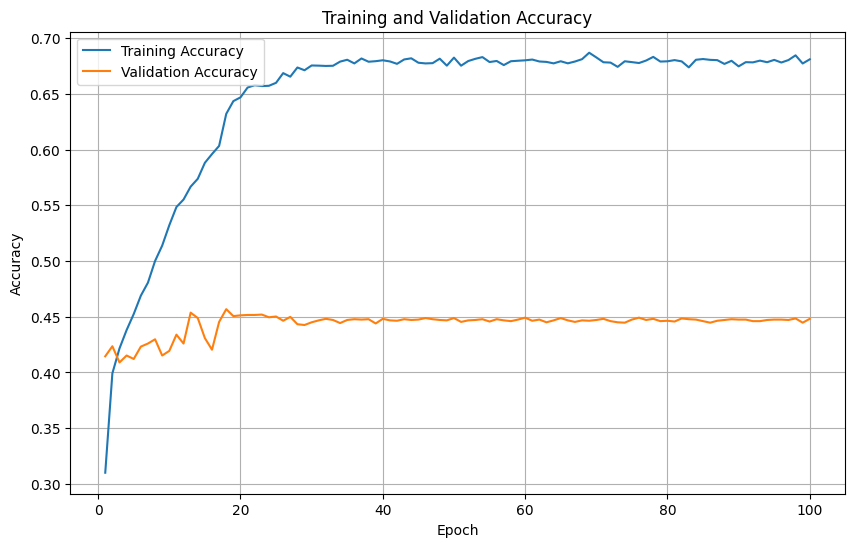

In [14]:
import matplotlib.pyplot as plt
num_epochs = 100
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

utils.test_model(model, test_loader)
end_time = time.time()

hours = (optim_end - start_time) // 3600
minutes = ((optim_end - start_time) % 3600) // 60
seconds = (optim_end - start_time) % 60

print(f'time to train hyperparameters: \
{hours} hours, \
{minutes} minutes, \
{int(seconds)} seconds')

print(f'time to train model: \
{hours} hours, \
{minutes} minutes, \
{int(seconds)} seconds')

Test acc: 0.479
time to train hyperparameters: 0.0 hours, 18.0 minutes, 1 seconds
time to train model: 0.0 hours, 18.0 minutes, 1 seconds


In [ ]:
# given (200, 22, 400) <=> (batch_size, channels, time_bins)
class CNN(nn.Module):
  def __init__(self, num_classes):
    super(CNN, self).__init__()

    # first block: convolve over time with kernel size 3.
    # out_channels: 25
    # activation: ReLU
    # uses standard dropout of 0.5
    self.conv1 = nn.Sequential(
        nn.Conv1d(in_channels=22, out_channels=25, kernel_size=10),
        nn.ReLU(),
        nn.BatchNorm1d(25),
        nn.Dropout(0.5)
    )

    # second block: convolve over space with kernel size (1, 22) to match dims.
    #               and a stride of 2.
    # out_channels: 25 * 2 = 50
    # activation: ELU
    # pooling: Mean pooling with kernel size (1, 3)
    # uses standard dropout of 0.5
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=25, out_channels=50, kernel_size=(1, 22), stride=2),
        nn.ELU(),
        nn.BatchNorm2d(50),
        nn.AvgPool2d(kernel_size=(1, 3)),
        nn.Dropout(0.5)
    )

    # third block: convolve over time with kernel size 5.
    #               and a stride of 2.
    # out_channels: 50 * 2 = 100
    # activation: ELU
    # pooling: Mean pooling with kernel size (1, 3)
    # uses standard dropout of 0.5
    self.conv3 = nn.Sequential(
        nn.Conv1d(in_channels=50, out_channels=100, kernel_size=5),
        nn.ELU(),
        nn.BatchNorm1d(100),
        nn.AvgPool2d(kernel_size=(1, 3)),
        nn.Dropout(0.5)
    )

    # fourth block: convolve over time with kernel size 5 and a stride of 3.
    # out_channels: 100 * 2 = 200
    # activation: ELU
    # pooling: Mean pooling with kernel size (1, 3)
    # uses standard dropout of 0.5
    self.conv4 = nn.Sequential(
        nn.Conv1d(in_channels=100, out_channels=200, kernel_size=5, stride=3),
        nn.ELU(),
        nn.BatchNorm1d(200),
        nn.MaxPool2d(kernel_size=(1, 3)),
        nn.Dropout(0.5)
    )

    # dense block: fully-connected affine layer
    self.dense = nn.Linear(in_features=200, out_features=num_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = x.unsqueeze(2)      # match dims for Conv2d().
    x = self.conv2(x)
    x = x.squeeze(2)        # match dims for Conv1d().
    x = self.conv3(x)
    x = self.conv4(x)
    x = torch.flatten(x, 1) # match dims for affine.
    x = self.dense(x)

    return F.log_softmax(x, dim=1)


In [ ]:
model = CNN(num_classes=4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate, weight_decay=5e-3)

In [ ]:
train_accuracies = []
val_accuracies = []

for epoch_idx in range(num_epochs):
    print(f'EPOCH {epoch_idx}')
    model.train() # setting model to train mode because some models behave differently when in training or evaluation (think dropout)
    train_count = 0
    train_correct_count = 0
    for batch_idx, (train_x, train_y) in enumerate(tqdm(train_loader)):
        train_x = train_x.float().to(device)
        train_y = train_y.long().to(device)

        # print(train_x.shape)
        logits = model(train_x)
        # print(logits.shape)
        loss = criterion(logits, train_y) # loss function needs logits here (look at docs)

        optimizer.zero_grad() # Zero gradients, since we don't want gradients to accumulate between batches - we apply an update for each batch
        # sometimes useful if you want to accumulate gradients across passes (in minibatch we dont want this)
        loss.backward() # do backwards pass
        optimizer.step() # take a step using gradients

        with torch.no_grad(): # stop gradients from being tracked (used when computing arbitrary statistics)
            y_hat = torch.argmax(logits, dim=-1)
            train_correct_count += torch.sum(y_hat == train_y, axis=-1)
            train_count += train_x.size(0)

    train_acc = train_correct_count / train_count # getting accuracy measure

    model.eval() # puts the model in eval mode
    val_count = 0
    val_correct_count = 0
    with torch.no_grad(): # dont want gradients to be computed
        for idx, (val_x, val_y) in enumerate(val_loader):
            val_x = val_x.float().to(device)
            val_y = val_y.long().to(device)
            logits = model(val_x).detach()
            y_hat = torch.argmax(logits, dim=-1) # choose most probable class in output
            #print(f"PRED: {y_hat}")
            #print(f"ACTUAL: {val_y}")
            val_correct_count += torch.sum(y_hat == val_y, axis=-1)
            val_count += val_y.size(0)
    val_acc = val_correct_count / val_count

    train_accuracies.append(train_acc.item())
    val_accuracies.append(val_acc.item())

    print('Train acc: {:.3f}, Val acc: {:.3f}'.format(train_acc, val_acc))

EPOCH 0


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 53.18it/s]


Train acc: 0.302, Val acc: 0.425
EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.84it/s]


Train acc: 0.417, Val acc: 0.547
EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 51.22it/s]


Train acc: 0.491, Val acc: 0.547
EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.25it/s]


Train acc: 0.542, Val acc: 0.482
EPOCH 4


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 54.96it/s]


Train acc: 0.565, Val acc: 0.515
EPOCH 5


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.71it/s]


Train acc: 0.584, Val acc: 0.412
EPOCH 6


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.28it/s]


Train acc: 0.608, Val acc: 0.519
EPOCH 7


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 54.59it/s]


Train acc: 0.626, Val acc: 0.501
EPOCH 8


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.35it/s]


Train acc: 0.639, Val acc: 0.620
EPOCH 9


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 54.10it/s]


Train acc: 0.654, Val acc: 0.454
EPOCH 10


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.44it/s]


Train acc: 0.666, Val acc: 0.502
EPOCH 11


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.59it/s]


Train acc: 0.676, Val acc: 0.659
EPOCH 12


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.17it/s]


Train acc: 0.695, Val acc: 0.596
EPOCH 13


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 52.62it/s]


Train acc: 0.691, Val acc: 0.354
EPOCH 14


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 54.31it/s]


Train acc: 0.687, Val acc: 0.515
EPOCH 15


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.12it/s]


Train acc: 0.702, Val acc: 0.542
EPOCH 16


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 58.86it/s]


Train acc: 0.712, Val acc: 0.612
EPOCH 17


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.30it/s]


Train acc: 0.722, Val acc: 0.545
EPOCH 18


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.68it/s]


Train acc: 0.720, Val acc: 0.684
EPOCH 19


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 54.40it/s]


Train acc: 0.740, Val acc: 0.624
EPOCH 20


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.37it/s]


Train acc: 0.726, Val acc: 0.590
EPOCH 21


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.23it/s]


Train acc: 0.733, Val acc: 0.645
EPOCH 22


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 53.05it/s]


Train acc: 0.744, Val acc: 0.566
EPOCH 23


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.00it/s]


Train acc: 0.739, Val acc: 0.402
EPOCH 24


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 53.21it/s]


Train acc: 0.745, Val acc: 0.580
EPOCH 25


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 54.10it/s]


Train acc: 0.747, Val acc: 0.623
EPOCH 26


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.19it/s]


Train acc: 0.766, Val acc: 0.517
EPOCH 27


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.72it/s]


Train acc: 0.767, Val acc: 0.620
EPOCH 28


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.26it/s]


Train acc: 0.768, Val acc: 0.494
EPOCH 29


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 52.39it/s]


Train acc: 0.762, Val acc: 0.527
EPOCH 30


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 53.10it/s]


Train acc: 0.748, Val acc: 0.618
EPOCH 31


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 50.43it/s]


Train acc: 0.767, Val acc: 0.519
EPOCH 32


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 54.90it/s]


Train acc: 0.764, Val acc: 0.521
EPOCH 33


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 58.90it/s]


Train acc: 0.782, Val acc: 0.678
EPOCH 34


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 58.85it/s]


Train acc: 0.791, Val acc: 0.505
EPOCH 35


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.90it/s]


Train acc: 0.770, Val acc: 0.552
EPOCH 36


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.34it/s]


Train acc: 0.783, Val acc: 0.502
EPOCH 37


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.43it/s]


Train acc: 0.783, Val acc: 0.529
EPOCH 38


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.45it/s]


Train acc: 0.782, Val acc: 0.442
EPOCH 39


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.64it/s]


Train acc: 0.764, Val acc: 0.657
EPOCH 40


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 53.80it/s]


Train acc: 0.799, Val acc: 0.656
EPOCH 41


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 58.42it/s]


Train acc: 0.804, Val acc: 0.646
EPOCH 42


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 54.63it/s]


Train acc: 0.801, Val acc: 0.630
EPOCH 43


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.66it/s]


Train acc: 0.804, Val acc: 0.616
EPOCH 44


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.56it/s]


Train acc: 0.807, Val acc: 0.554
EPOCH 45


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 37.81it/s]


Train acc: 0.801, Val acc: 0.518
EPOCH 46


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.85it/s]


Train acc: 0.807, Val acc: 0.650
EPOCH 47


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.92it/s]


Train acc: 0.808, Val acc: 0.456
EPOCH 48


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 49.03it/s]


Train acc: 0.739, Val acc: 0.631
EPOCH 49


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.65it/s]


Train acc: 0.794, Val acc: 0.658
EPOCH 50


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.71it/s]


Train acc: 0.809, Val acc: 0.639
EPOCH 51


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.57it/s]


Train acc: 0.808, Val acc: 0.624
EPOCH 52


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.58it/s]


Train acc: 0.810, Val acc: 0.620
EPOCH 53


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.91it/s]


Train acc: 0.813, Val acc: 0.548
EPOCH 54


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 58.27it/s]


Train acc: 0.805, Val acc: 0.488
EPOCH 55


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.91it/s]


Train acc: 0.811, Val acc: 0.664
EPOCH 56


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.76it/s]


Train acc: 0.820, Val acc: 0.675
EPOCH 57


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.10it/s]


Train acc: 0.823, Val acc: 0.538
EPOCH 58


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.11it/s]


Train acc: 0.816, Val acc: 0.699
EPOCH 59


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 59.75it/s]


Train acc: 0.824, Val acc: 0.593
EPOCH 60


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.79it/s]


Train acc: 0.810, Val acc: 0.665
EPOCH 61


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.15it/s]


Train acc: 0.825, Val acc: 0.564
EPOCH 62


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.57it/s]


Train acc: 0.814, Val acc: 0.581
EPOCH 63


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.37it/s]


Train acc: 0.816, Val acc: 0.637
EPOCH 64


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.12it/s]


Train acc: 0.814, Val acc: 0.644
EPOCH 65


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.65it/s]


Train acc: 0.819, Val acc: 0.617
EPOCH 66


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.83it/s]


Train acc: 0.823, Val acc: 0.657
EPOCH 67


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 58.18it/s]


Train acc: 0.816, Val acc: 0.532
EPOCH 68


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.36it/s]


Train acc: 0.807, Val acc: 0.554
EPOCH 69


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.73it/s]


Train acc: 0.815, Val acc: 0.567
EPOCH 70


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.26it/s]


Train acc: 0.816, Val acc: 0.670
EPOCH 71


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.08it/s]


Train acc: 0.840, Val acc: 0.587
EPOCH 72


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.13it/s]


Train acc: 0.832, Val acc: 0.584
EPOCH 73


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.91it/s]


Train acc: 0.828, Val acc: 0.686
EPOCH 74


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.14it/s]


Train acc: 0.847, Val acc: 0.665
EPOCH 75


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.24it/s]


Train acc: 0.830, Val acc: 0.637
EPOCH 76


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.05it/s]


Train acc: 0.824, Val acc: 0.593
EPOCH 77


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.59it/s]


Train acc: 0.837, Val acc: 0.642
EPOCH 78


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.93it/s]


Train acc: 0.830, Val acc: 0.665
EPOCH 79


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.73it/s]


Train acc: 0.838, Val acc: 0.688
EPOCH 80


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.06it/s]


Train acc: 0.832, Val acc: 0.526
EPOCH 81


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.43it/s]


Train acc: 0.827, Val acc: 0.676
EPOCH 82


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.48it/s]


Train acc: 0.837, Val acc: 0.656
EPOCH 83


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.11it/s]


Train acc: 0.845, Val acc: 0.700
EPOCH 84


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.65it/s]


Train acc: 0.843, Val acc: 0.673
EPOCH 85


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.71it/s]


Train acc: 0.839, Val acc: 0.607
EPOCH 86


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.75it/s]


Train acc: 0.842, Val acc: 0.685
EPOCH 87


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.41it/s]


Train acc: 0.840, Val acc: 0.550
EPOCH 88


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 50.91it/s]


Train acc: 0.806, Val acc: 0.645
EPOCH 89


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 54.62it/s]


Train acc: 0.838, Val acc: 0.669
EPOCH 90


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.70it/s]


Train acc: 0.841, Val acc: 0.676
EPOCH 91


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.41it/s]


Train acc: 0.846, Val acc: 0.624
EPOCH 92


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.91it/s]


Train acc: 0.836, Val acc: 0.682
EPOCH 93


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.26it/s]


Train acc: 0.837, Val acc: 0.478
EPOCH 94


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.12it/s]


Train acc: 0.805, Val acc: 0.640
EPOCH 95


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.34it/s]


Train acc: 0.833, Val acc: 0.692
EPOCH 96


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 58.96it/s]


Train acc: 0.843, Val acc: 0.682
EPOCH 97


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.73it/s]


Train acc: 0.844, Val acc: 0.690
EPOCH 98


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 58.59it/s]


Train acc: 0.846, Val acc: 0.676
EPOCH 99


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 58.13it/s]

Train acc: 0.845, Val acc: 0.716


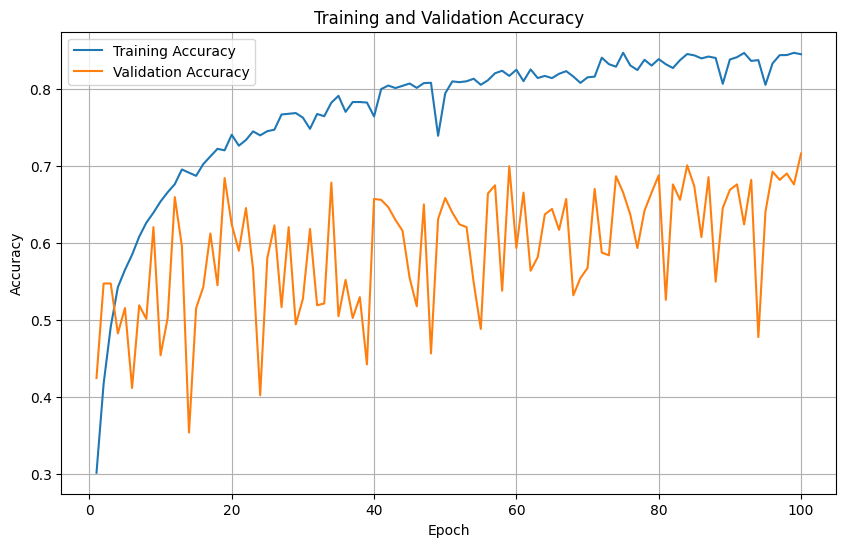

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    test_count = 0
    test_correct_count = 0
    for idx, (test_x, test_y) in enumerate(test_loader):
        test_x = test_x.float().to(device)
        test_y = test_y.long().to(device)
        logits = model(test_x).detach()
        y_hat = torch.argmax(logits, dim=-1)
        test_correct_count += torch.sum(y_hat == test_y, axis=-1)
        test_count += test_x.size(0)
    test_acc = test_correct_count / test_count
    print('Test acc: {:.3f}'.format(test_acc))

Test acc: 0.713
